# Smoothness analysis with inertial measurement units

This notebooks demonstrates how to use the `quality` package of the ``monalysa`` library to analyse movement smoothness. This notebook also makes use of the ``experimental.py`` module for segmenting the movement data into individual movement segments.

Contact siva82kb@gmail.com for any queries.

### Install the most recent monalysa library

In [1]:
import sys
sys.path.append('../../../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

In [3]:
from monalysa import quality
from monalysa import misc
from monalysa import experimetal

In [4]:
import pathlib
from datetime import datetime as dt
from datetime import timedelta as td

### Analysis Code

In [98]:
# Data directory.
datadir = pathlib.Path("../../../data/ag_data/mocap_ag_expt")

# AG/MOCAP file names.
files2read = {
    "p2preach": "reaching.csv",
    "viareach1": "reaching_via1.csv",
    "viareach2": "reaching_via2.csv",
    "grasp1": "grasp_object1.csv",
    "grasp2": "grasp_object2.csv"
}

# Segmentation parameters for the experimetal.get_move_segment_times function.
seg_params = {
    "p2preach": {"on": 0.5, "off": 0.5},
    "viareach1": {"on": 0.8, "off": 0.5},
    "viareach2": {"on": 0.8, "off": 0.5},
    "grasp1": {"on": 0.8, "off": 0.5},
    "grasp2": {"on": 0.5, "off": 0.6},
}

# Smoothness vaules
ldlj_mc = {}
sparc_mc = {}
ldlj_ag = {}

In [135]:
# Read the motion capture data
expt = "grasp2"
mc_data = pd.read_csv((datadir / files2read[expt]).as_posix())
mc_data['datetime'] = pd.to_datetime(mc_data['datetime'], format="%Y-%m-%d %H:%M:%S")

# Actigraph maker columsn
agcols = ['actix', 'actiy', 'actiz']

# Estimate velocity of the AG marker.
t = mc_data['datetime'].values
tsamp = td(microseconds=(t[1] - t[0]).astype(int) / 1000).microseconds / 1000000
fsamp = 1 / tsamp
_pos = mc_data[agcols].values
_vel = misc.smoothed_derivative(data=_pos, tsamp=tsamp, twin=0.5)

# Start-stop timestamps
# mcstrstpts = experimetal.get_move_segment_times(vel=_vel, speedth=0.05, durtol=0.2)
mcstrstpts = experimetal.get_move_segment_times(
    vel=_vel, delt=tsamp, speedth=0.05,
    onth=seg_params[expt]["on"], offth=seg_params[expt]["off"],
    remove_on_before_off=True,
    durtol=0.15
)

# Read Actigraph data
ag_data = pd.read_csv((datadir / "ag_data.csv").as_posix())
ag_data['datetime'] = pd.to_datetime(ag_data['datetime'], format="%Y-%m-%d %H:%M:%S")
# Filter accelerometer data
nwin, polyorder = 21, 0
ag_data['actix_f'] = signal.savgol_filter(ag_data['actix'], nwin, polyorder, deriv=0,
                                          delta=1/fsamp, mode='mirror')
ag_data['actiy_f'] = signal.savgol_filter(ag_data['actiy'], nwin, polyorder, deriv=0,
                                          delta=1/fsamp, mode='mirror')
ag_data['actiz_f'] = signal.savgol_filter(ag_data['actiz'], nwin, polyorder, deriv=0,
                                          delta=1/fsamp, mode='mirror')

In [136]:
# Merge AG and MOCAP data by common timestamps.
mcag_data = mc_data.join(ag_data.set_index('datetime', inplace=False),
                         on='datetime', how='inner', lsuffix='_mc',
                         rsuffix='_ag')

### Plot of entire data data with the identified segments

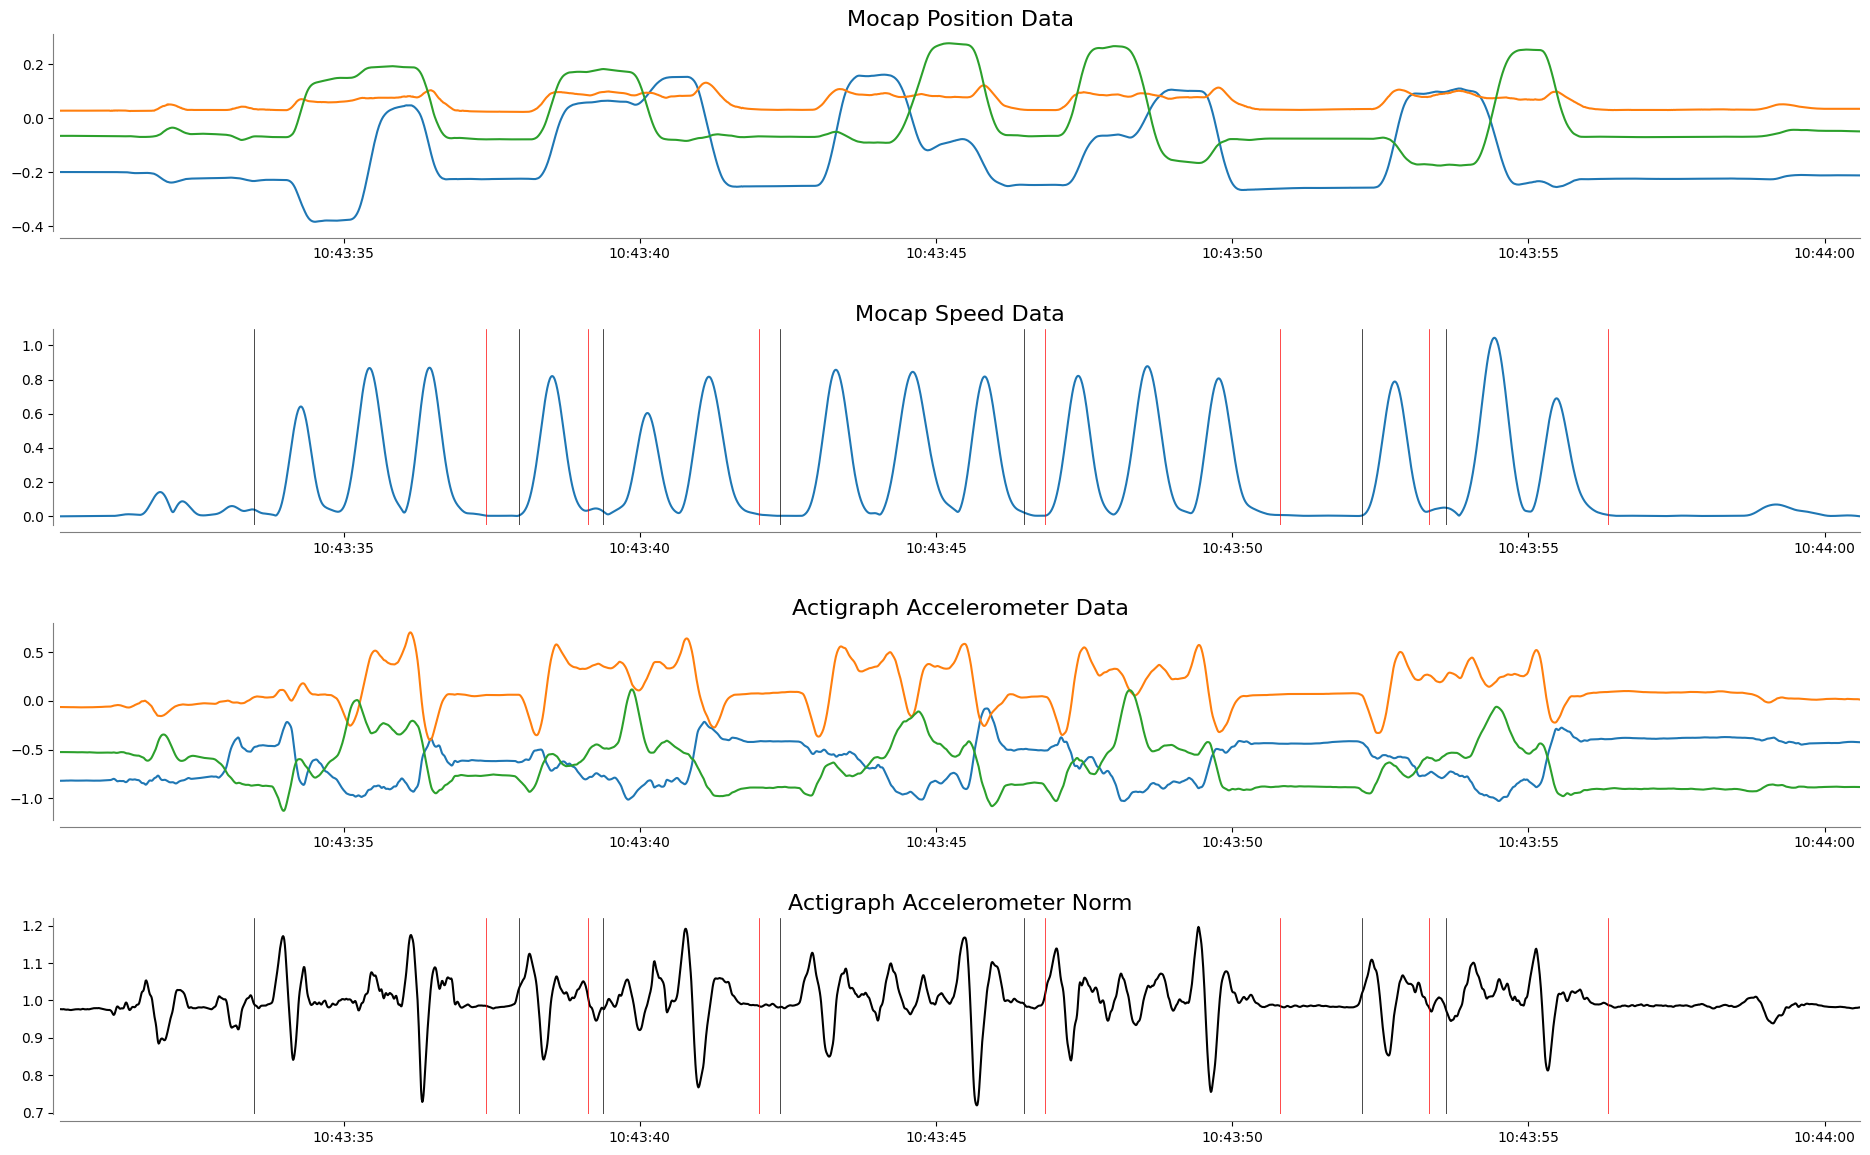

In [137]:
# Plot of MOCAP and AG Data for the task.
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(411)
ax.plot(t, _pos)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_title("Mocap Position Data", fontsize=16)
ax.set_xlim(t[0], t[-1])
ax = fig.add_subplot(412)
ax.plot(t, np.linalg.norm(_vel, axis=1))
for i in range(len(mcstrstpts)):
    ax.axvline(t[mcstrstpts[i, 0]], color='k', linewidth=0.5)
    ax.axvline(t[mcstrstpts[i, 1]], color='r', linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_title("Mocap Speed Data", fontsize=16)
ax.set_xlim(t[0], t[-1])
ax = fig.add_subplot(413)
ax.plot(t, mcag_data['actix_f'])
ax.plot(t, mcag_data['actiy_f'])
ax.plot(t, mcag_data['actiz_f'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_title("Actigraph Accelerometer Data", fontsize=16)
ax.set_xlim(t[0], t[-1])
ax = fig.add_subplot(414)
_agaccl = np.linalg.norm(mcag_data[['actix_f', 'actiy_f', 'actiz_f']].values, axis=1)
ax.plot(t, _agaccl, color="k")
for i in range(len(mcstrstpts)):
    ax.axvline(t[mcstrstpts[i, 0]], color='k', linewidth=0.5)
    ax.axvline(t[mcstrstpts[i, 1]], color='r', linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_title("Actigraph Accelerometer Norm", fontsize=16)
ax.set_xlim(t[0], t[-1])
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                    wspace=0.0, hspace=0.5)


### Plot of the segmented movements

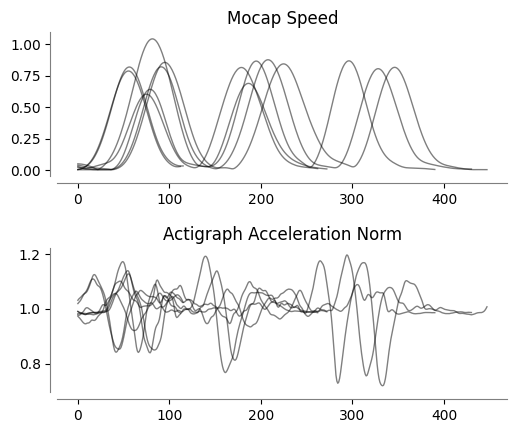

In [129]:
# Segment movements into indidivual discrete movements.
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(211)
_speed = np.linalg.norm(_vel, axis=1)
for _strt, _stp in mcstrstpts:
    ax.plot(_speed[_strt:_stp], color="k", lw=1, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_title("Mocap Speed", fontsize=12)
ax = fig.add_subplot(212)
_agaccl = np.linalg.norm(mcag_data[['actix_f', 'actiy_f', 'actiz_f']].values, axis=1)
for _strt, _stp in mcstrstpts:
    ax.plot(_agaccl[_strt:_stp], color="k", lw=1, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_title("Actigraph Acceleration Norm", fontsize=12)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                    wspace=0.0, hspace=0.5)

### Compute Smoothness from the motion capture data using LDLJ and SPARC

In [130]:
# Computer Smoothness
# Mocap Smoothness using LDLJ and SPARC
ldlj_mc[expt] = np.zeros(len(mcstrstpts))
sparc_mc[expt] = np.zeros(len(mcstrstpts))
for i, (strt, stp) in enumerate(mcstrstpts):
    # Movement is not too short.
    _speed = np.linalg.norm(_vel[strt:stp, :], axis=1)
    ldlj_mc[expt][i] = quality.smoothness.log_dimensionless_jerk(
        _vel[strt:stp, :], fs=fsamp, data_type="vel"
    )
    sparc_mc[expt][i] = quality.smoothness.sparc(_speed, fs=fsamp)[0]

### Compute Smoothness from the Actigraph accelerometer data using the LDLJ

In [131]:
# Actigraph Smoothness using LDLJ
ldlj_ag[expt] = np.zeros(len(mcstrstpts))
for i, (strt, stp) in enumerate(mcstrstpts):
    # Movement is not too short.
    _accl = mcag_data[['actix_f', 'actiy_f', 'actiz_f']].values[strt:stp, :]
    ldlj_ag[expt][i] = quality.smoothness.log_dimensionless_jerk_imu(
        accls=_accl, gyros=None,fs=fsamp
    )

### Comparison of the different smoothness values

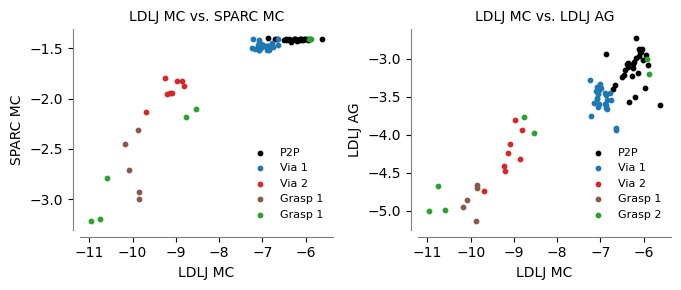

In [132]:
# Scatter plot of smoothness values for the different reaching experiments.
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(121)
ax.scatter(ldlj_mc["p2preach"], sparc_mc["p2preach"], color="k", s=10, label="P2P")
ax.scatter(ldlj_mc["viareach1"], sparc_mc["viareach1"], color="tab:blue", s=10, label="Via 1")
ax.scatter(ldlj_mc["viareach2"], sparc_mc["viareach2"], color="tab:red", s=10, label="Via 2")
ax.scatter(ldlj_mc["grasp1"], sparc_mc["grasp1"], color="tab:brown", s=10, label="Grasp 1")
ax.scatter(ldlj_mc["grasp2"], sparc_mc["grasp2"], color="tab:green", s=10, label="Grasp 1")
ax.legend(loc="lower right", fontsize=8, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_xlabel("LDLJ MC", fontsize=10)
ax.set_ylabel("SPARC MC", fontsize=10)
ax.set_title("LDLJ MC vs. SPARC MC", fontsize=10)
ax = fig.add_subplot(122)
ax.scatter(ldlj_mc["p2preach"], ldlj_ag["p2preach"], color="k", s=10, label="P2P")
ax.scatter(ldlj_mc["viareach1"], ldlj_ag["viareach1"], color="tab:blue", s=10, label="Via 1")
ax.scatter(ldlj_mc["viareach2"], ldlj_ag["viareach2"], color="tab:red", s=10, label="Via 2")
ax.scatter(ldlj_mc["grasp1"], ldlj_ag["grasp1"], color="tab:brown", s=10, label="Grasp 1")
ax.scatter(ldlj_mc["grasp2"], ldlj_ag["grasp2"], color="tab:green", s=10, label="Grasp 2")
ax.legend(loc="lower right", fontsize=8, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_xlabel("LDLJ MC", fontsize=10)
ax.set_ylabel("LDLJ AG", fontsize=10)
ax.set_title("LDLJ MC vs. LDLJ AG", fontsize=10)

plt.tight_layout()